# Notebook 13 a) Binary Sentiment Model Using ML Models

This notebook uses the noun phrases to run the same machine learning classifiers as used in Notebook 7 (Text Content Sentiment Models). However, the data here is not at review level, it has been split down into sentences and the noun phrases extracted. VADER was used to determine polarity of each noun phrase and therefore a binary score could be applied as before. The data set is very imbalanced so the majority class was random under-sampled to give a dataset similar in size of around 8,000 rows compared to the original dataset of 73,000. The output of this model is BINARY - positive or negative.

* Section 1 - Import libraries and dataset
* Section 2 - Feature Presence Vector (One-hot encoding)
* Section 3 - Feature Presence Vector Bigram
* Section 4 - BOW unigram vector
* Section 5 - BOW bigram vector
* Section 6 - TFIDF unigram vector
* Section 7 - TFIDF bigram vector
* Section 8 - Classification models training accuracy
* Section 9 - Predict on validation set
* Section 10 - Summary Table of Results
* Section 11 - Hyperparameter tuning
* Section 12 - Grid search CV

Datasets needed to run notebook:

* combined_sentiment.csv
* combined_sentiment_test.csv


# Section 1: Import libraries and dataset

In [5]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, KFold,cross_val_score,learning_curve,validation_curve,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import imblearn
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_curve,auc,roc_auc_score,precision_recall_curve,plot_precision_recall_curve,f1_score,fbeta_score,f1_score,precision_score,recall_score
import scipy.sparse
import pickle

In [6]:
# Bring in training and test sets from Notebook 11 (visualising topic models)
df_train = pd.read_csv("combined_sentiment.csv",index_col = 0)
df_test = pd.read_csv("combined_sentiment_test.csv",index_col = 0)

# Combine train and test set
df_combined_all = pd.concat([df_train, df_test],axis = 0,ignore_index = True)
df_combined_all.shape

(73027, 15)

In [7]:
df_combined_all.head(2)

,Unnamed: 0.1,OrigInd,Category,Town,Rating,all_text,cleaned,noun_phrases,nouns,Topic Count,Topic TFIDF,Sentiment,Score,Sentence,Topic
0,0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,shame accommodation,"['shame', 'accommodation']",VFM,VisitExp,-0.4767,negative,NaN,NaN
1,1,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,night stay december post-christmas,"['night', 'post-christmas']",Hotel Location,Restaurant,0.0000,neutral,NaN,NaN


# Section 2: Data processing

In [8]:
df_combined_all.shape

(73027, 15)

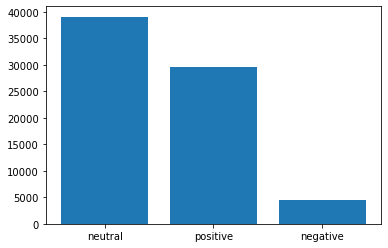

In [9]:
# Distribution of polarities
sent = pd.DataFrame(df_combined_all["Score"].value_counts())
plt.bar(sent.index,sent["Score"])
plt.show()

In [10]:
# Drop the neutral sentiment and set 0 to positive and 1 to negative
df_combined_all = df_combined_all[df_combined_all["Score"]!="neutral"]
df_combined_all["Score"].replace({"positive": 0,"negative":1}, inplace=True)
df_combined_all["Score"].value_counts()

0    29513
1     4415
Name: Score, dtype: int64

The dataset is imbalanced. Over sampling would create a dataset with a lot of duplicates and under sampling would produce a much smaller dataset. Class weights can be used with all models except Naive Bayes but this would be very intensive since the dataset is so large. Therefore, undersampling of the majority class is chosen as a method to address the imbalance.

In [11]:
X = df_combined_all["noun_phrases"]
y = df_combined_all["Score"]

In [12]:
print(X.shape, y.shape)

(33928,) (33928,)


In [13]:
X = np.array(X).reshape(-1, 1)

In [14]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority',random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [15]:
print(X_resampled.shape,y_resampled.shape)
y_resampled.value_counts()

(8830, 1) (8830,)


0    4415
1    4415
Name: Score, dtype: int64

In [110]:
# Split into training and test set as before
# Function to split each balanced dataframe into training, validation and test splits with a stratified rating value
# It is noted that the train and test sets will not be exactly the same as for the Post Review Models due to the need to process
# each dataframe differently but is unlikely to make a large difference to the results.

def splitting(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.2, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,stratify = y_test, test_size=0.50, random_state=42)     
    return X_train,y_train,X_val,y_val,X_test,y_test

In [111]:
# Run function
X_train,y_train,X_val,y_val,X_test,y_test = splitting(X_resampled,y_resampled)
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(7064, 1) (7064,) (883, 1) (883,) (883, 1) (883,)


In [112]:
X_train = [item for sublist in X_train for item in sublist]
X_val = [item for sublist in X_val for item in sublist]
X_test = [item for sublist in X_test for item in sublist]

# Section 2: Feature Presence (One-Hot Encoding)

In [113]:
# Apply to training dataset and valuation dataset - not binary set to true for one hot encoded feature presence vector
vectorizer1 = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english", binary = True)
vectorizer1.fit(X_train)

# Transform the training and test set to vectors
X_train_fp = vectorizer1.transform(X_train)
X_val_fp = vectorizer1.transform(X_val)
X_test_fp = vectorizer1.transform(X_test)

In [114]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix
print(X_train_fp.shape, X_val_fp.shape)

(7064, 3186) (883, 3186)


# Section 3: Feature Presence Bigram Model

In [115]:
# Apply to training dataset and valuation dataset
vectorizer2 = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english", binary = True, ngram_range=(1, 2))
vectorizer2.fit(X_train)

# Transform the training and test set to vectors
X_train_fp_big = vectorizer2.transform(X_train)
X_val_fp_big = vectorizer2.transform(X_val)
X_tes_fp_big = vectorizer2.transform(X_test)

In [116]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix
print(X_train_fp_big.shape, X_val_fp_big.shape, X_test_fp.shape)

(7064, 13314) (883, 13314) (883, 3186)


# Section 4: Count Frequency Model

In [117]:
# Apply to training dataset and valuation dataset
vectorizer3 = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english")
vectorizer3.fit(X_train)

# Transform the training and test set to vectors
X_train_bow = vectorizer3.transform(X_train)
X_val_bow = vectorizer3.transform(X_val)
X_test_bow = vectorizer3.transform(X_test)

In [118]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix
print(X_train_bow.shape, X_val_bow.shape, y_train.shape, y_val.shape, X_test_bow.shape, y_test.shape)

(7064, 3186) (883, 3186) (7064,) (883,) (883, 3186) (883,)


# Section 5: Countvectorizer Bigram Model

In [119]:
# Apply to whole dataset with unigrams and bigrams. Set up ngram vectorizer and fit to training data
# words must appear in at least 2 documents and not in more than 98% of documents to limit the vocabulary size
vectorizer4 = CountVectorizer(analyzer='word', max_df=0.98, stop_words = "english",min_df=2, ngram_range=(1,2))
vectorizer4.fit(X_train)

# Transform the training and test set to vectors for use in model training and predicting
X_train_ngram = vectorizer4.transform(X_train)
X_val_ngram = vectorizer4.transform(X_val)
X_test_ngram = vectorizer4.transform(X_test)

In [120]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix. Ten times as many
# words and ngrams in the training and test set compared to the BOW model
print(X_train_ngram.shape, X_val_ngram.shape, y_train.shape, y_val.shape, X_test_ngram.shape, y_test.shape)

(7064, 2980) (883, 2980) (7064,) (883,) (883, 2980) (883,)


# Section 6 :TFIDF Vectorizer - Unigram Model

In [121]:
# Set up countvectorizer based on ngrams for the whole corpus based on unigrams only and fit to training set
vectorizer5 = TfidfVectorizer(use_idf = True, max_df = 1.0,min_df = 1, stop_words = "english",smooth_idf = True, norm = 'l2')
np.set_printoptions(precision = 2)
vectorizer5.fit(X_train)

TfidfVectorizer(stop_words='english')

In [122]:
# Function to save tokenizer object
def save_tok(name,file):
    with open(name, 'wb') as handle:
        pickle.dump(file, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [123]:
# Save for combined model
save_tok('sent_tok.pickle',vectorizer5)

In [124]:
# Transform the training and test set to vectors for use in model training and predicting
X_train_tfidf1 = vectorizer5.transform(X_train)
X_val_tfidf1 = vectorizer5.transform(X_val)
X_test_tfidf1 = vectorizer5.transform(X_test)

In [125]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix.Same as BOW
print(X_train_tfidf1.shape, X_val_tfidf1.shape, y_train.shape, y_val.shape, X_test_tfidf1.shape, y_test.shape)

(7064, 3186) (883, 3186) (7064,) (883,) (883, 3186) (883,)


# Section 7: TFIDF - BIGRAM MODEL

In [32]:
# Set up countvectorizer based on ngrams for the whole corpus based on unigrams only and fit to training set
vectorizer6 = TfidfVectorizer(use_idf = True, max_df = 0.98,min_df =2,stop_words = "english",ngram_range=(1,2),smooth_idf = True, norm = 'l2')
np.set_printoptions(precision = 2)
vectorizer6.fit(X_train)

TfidfVectorizer(max_df=0.98, min_df=2, ngram_range=(1, 2), stop_words='english')

In [33]:
# Transform the training and test set to vectors for use in model training and predicting
X_train_tfidf2 = vectorizer6.transform(X_train)
X_val_tfidf2 = vectorizer6.transform(X_val)

In [34]:
# Size of training and test sets. The number of columns is the number of words in the document term matrix.Same as BOW
print(X_train_tfidf2.shape, X_val_tfidf2.shape, y_train.shape, y_val.shape)

(7064, 2980) (883, 2980) (7064,) (883,)


# Section 8: Training Accuracy on Each of the Vectorizer Objects

In [35]:
# Set models
dummy_model = DummyClassifier(strategy ='uniform')
nb = MultinomialNB()
lr = LogisticRegression(class_weight = "balanced")
rf = RandomForestClassifier(class_weight = "balanced")
svm = SVC(probability = True, class_weight = "balanced")

In [36]:
# Function to train with specified model on the training set - 10 fold as the dataset for ngrams is very large

def train_accuracy(model,X,y,vector):
    kf = KFold(n_splits = 10, shuffle = True, random_state = 1)
    cv_results = cross_val_score(model, X, y, cv = kf, scoring = "accuracy", n_jobs =-1)
    train_accuracy.results = pd.DataFrame({vector:cv_results.mean()}, index = [0])
                                

## Dummy Classifier

In [37]:
# BOW
train_accuracy(dummy_model,X_train_bow,y_train,"BOW-dum")
dum_train_bow = train_accuracy.results
dum_train_bow

,BOW-dum
0,0.498306


## Naive Bayes

In [38]:
# Feature Presence
train_accuracy(nb,X_train_fp, y_train, "FP")
nb_train_fp = train_accuracy.results

# Feature Presence Bigram
train_accuracy(nb,X_train_fp_big, y_train, "FP BIG")
nb_train_fp_big = train_accuracy.results

# BOW
train_accuracy(nb,X_train_bow,y_train,"BOW")
nb_train_bow = train_accuracy.results

# ngram
train_accuracy(nb,X_train_ngram,y_train,"BIGRAM")
nb_train_ngram = train_accuracy.results

# TFIDF unigram
train_accuracy(nb,X_train_tfidf1,y_train,"TFIDF UNI")
nb_train_tfidf1 = train_accuracy.results

# TFIDF bigram
train_accuracy(nb,X_train_tfidf2,y_train,"TFIDF BI")
nb_train_tfidf2 = train_accuracy.results

## Logistic Regression

In [39]:
# Feature Presence
train_accuracy(lr,X_train_fp, y_train, "FP")
lr_train_fp = train_accuracy.results

# Feature Presence Bigram
train_accuracy(lr,X_train_fp_big, y_train, "FP BIG")
lr_train_fp_big = train_accuracy.results

# BOW
train_accuracy(lr,X_train_bow,y_train,"BOW")
lr_train_bow = train_accuracy.results

# ngrams
train_accuracy(lr,X_train_ngram,y_train,"BIGRAM")
lr_train_ngram = train_accuracy.results

# TFIDF unigrams
train_accuracy(lr,X_train_tfidf1,y_train,"TFIDF UNI")
lr_train_tfidf1 = train_accuracy.results

# TFIDF bigrams
train_accuracy(lr,X_train_tfidf2,y_train,"TFIDF BI")
lr_train_tfidf2 = train_accuracy.results

## Random Forest

In [40]:
# Feature Presence
train_accuracy(rf,X_train_fp, y_train, "FP")
rf_train_fp = train_accuracy.results

# Feature Presence Bigram
train_accuracy(rf,X_train_fp_big, y_train, "FP BIG")
rf_train_fp_big = train_accuracy.results

# BOW
train_accuracy(rf,X_train_bow,y_train,"BOW")
rf_train_bow = train_accuracy.results

# bigrams
train_accuracy(rf,X_train_ngram,y_train,"BIGRAM")
rf_train_ngram = train_accuracy.results

# TFIDF unigrams
train_accuracy(rf,X_train_tfidf1,y_train,"TFIDF UNI")
rf_train_tfidf1 = train_accuracy.results

# TFIDF bigrams
train_accuracy(rf,X_train_tfidf2,y_train,"TFIDF BI")
rf_train_tfidf2 = train_accuracy.results

## Support Vector Machines

In [41]:
# Feature Presence
train_accuracy(svm,X_train_fp, y_train, "FP")
svm_train_fp = train_accuracy.results

# Feature Presence Bigram
train_accuracy(svm,X_train_fp_big, y_train, "FP BIG")
svm_train_fp_big = train_accuracy.results

# BOW
train_accuracy(svm,X_train_bow,y_train,"BOW")
svm_train_bow = train_accuracy.results

# bigrams
train_accuracy(svm,X_train_ngram,y_train,"BIGRAM")
svm_train_ngram = train_accuracy.results

# TFIDF unigrams
train_accuracy(svm,X_train_tfidf1,y_train,"TFIDF UNI")
svm_train_tfidf1 = train_accuracy.results

# TFIDF bigrams
train_accuracy(svm,X_train_tfidf2,y_train,"TFIDF BI")
svm_train_tfidf2 = train_accuracy.results

In [42]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]
fp = pd.concat([nb_train_fp, lr_train_fp, rf_train_fp, svm_train_fp])
fp_big = pd.concat([nb_train_fp_big, lr_train_fp_big, rf_train_fp_big, svm_train_fp_big])
bow = pd.concat([nb_train_bow,lr_train_bow,rf_train_bow,svm_train_bow])
big = pd.concat([nb_train_ngram,lr_train_ngram,rf_train_ngram,svm_train_ngram])
tfidf = pd.concat([nb_train_tfidf1,lr_train_tfidf1,rf_train_tfidf1,svm_train_tfidf1])
tfidf_big = pd.concat([nb_train_tfidf2,lr_train_tfidf2,rf_train_tfidf2,svm_train_tfidf2])

In [43]:
all_models = pd.concat([fp,fp_big,bow,big,tfidf,tfidf_big],axis = 1)
all_models.set_index([models],inplace = True)
all_models

,FP,FP BIG,BOW,BIGRAM,TFIDF UNI,TFIDF BI
Multinomial NB,0.956823,0.955833,0.956540,0.953427,0.955689,0.956540
Logistic Regression,0.961920,0.957531,0.961212,0.961354,0.954275,0.957530
Random Forest,0.948756,0.942103,0.949040,0.950314,0.949037,0.952436
Support Vector Machine,0.958808,0.946209,0.958241,0.954985,0.964469,0.962488


SVM TFIDF Unigram has the best accuracy

# Section 9: Prediction on validation set with each of the Models

In [44]:
# Diagnostic and Graphing Function from previous modelling

def run_mod(model,X_train,y_train,X_val,y_val):
        
    
    # Fit model on training set and predict on test set
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
                    
    # Classification Report
    print(classification_report(y_val, y_pred))
    
    # Learning Curve    
    train_sizes, train_scores, test_scores = learning_curve(model,X_train,y_train, scoring = "accuracy",
                                                            n_jobs =-1,train_sizes = np.linspace(0.01,1.0,50))
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.mean(test_scores, axis = 1)
    
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
    # ROC Curve and AUC score
    target_probs = model.predict_proba(X_val)[:,1]
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_val, target_probs)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # Precision-Recall Curve 
    precision, recall, thresholds = precision_recall_curve(y_val,target_probs)
    no_skill = len(y_val[y_val==1]) / len(y_val)
    plt.plot(recall, precision, marker='.')
    plt.plot([0, 1], [no_skill,no_skill], linestyle='--', label='No Skill Model')
    plt.title("Precision Recall Curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
    # histogram of predicted probabilities of the positive class
    plt.hist(target_probs)
    plt.xlim(0,1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of Bad Review')
    plt.ylabel('Frequency')
       
    # Test Set Metrics
    accuracy = accuracy_score(y_val, y_pred)
    rocauc = roc_auc_score(y_val,target_probs)
    auc_score = auc(recall,precision)
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')
    f1 = f1_score(y_val, y_pred, average='binary')
    f2_score = fbeta_score(y_val, y_pred, beta =2.0, labels=None, pos_label=1)
       
    
    run_mod.results = pd.DataFrame({"Accuracy":accuracy, "Precision":precision, "Recall":recall,
                                    "F1":f1,"ROCAUC":rocauc}, index = [0]
                                  )
 
    # y_pred is an array of predictions
    best_thresh = None
    best_score = 0
    for thresh in np.arange(0.1, 0.501, 0.01):
        score = f1_score(y_val, y_pred>thresh)
        if score > best_score:
            best_thresh = thresh
            best_score = score
    print("Best F1 score:",best_score , "Best threshold value:",best_thresh)
                
    # Confusion Matrix
    fig, ax = plt.subplots()
    cf_matrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    _ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
    _ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)

## Feature Presence

### Naive Bayes

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       442
           1       0.97      0.94      0.96       441

    accuracy                           0.96       883
   macro avg       0.96      0.96      0.96       883
weighted avg       0.96      0.96      0.96       883



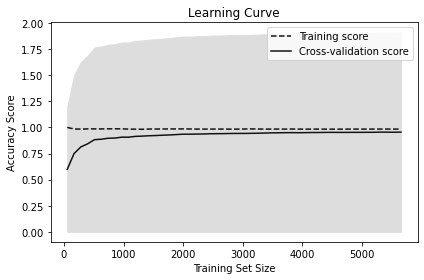

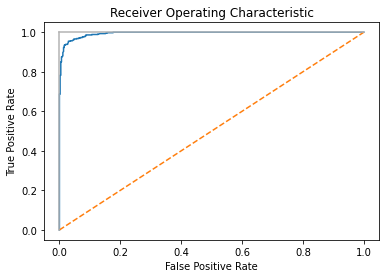

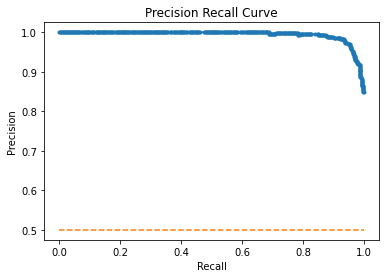

Best F1 score: 0.957422324510932 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,ROCAUC
0,0.958097,0.971963,0.943311,0.957422,0.994036


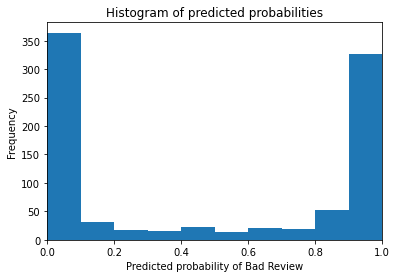

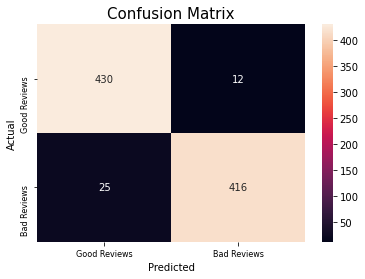

In [45]:
run_mod(nb,X_train_fp,y_train,X_val_fp,y_val)
nb_results1 = run_mod.results
nb_results1

### Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       442
           1       0.94      0.98      0.96       441

    accuracy                           0.96       883
   macro avg       0.96      0.96      0.96       883
weighted avg       0.96      0.96      0.96       883



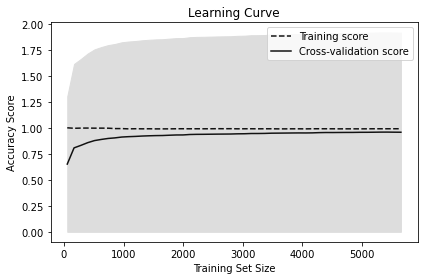

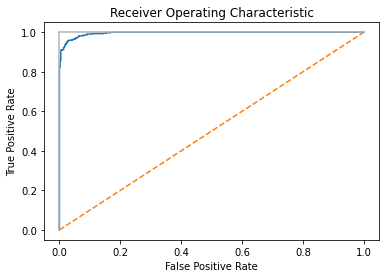

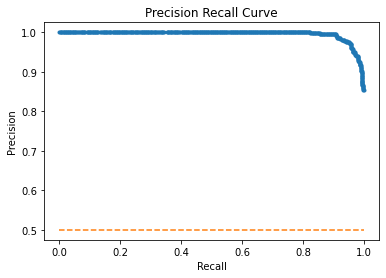

Best F1 score: 0.9587513935340023 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,ROCAUC
0,0.958097,0.942982,0.975057,0.958751,0.995396


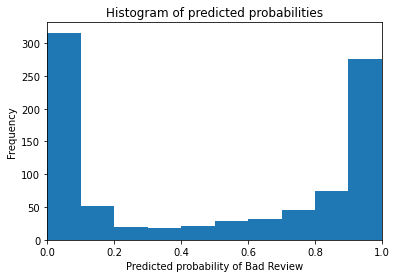

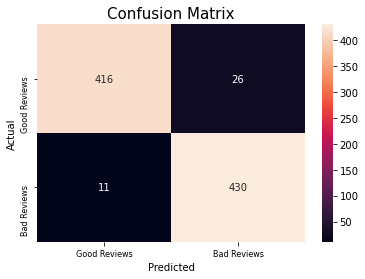

In [46]:
run_mod(lr,X_train_fp,y_train,X_val_fp,y_val)
lr_results1 = run_mod.results
lr_results1

### Random Forest

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       442
           1       0.93      0.97      0.95       441

    accuracy                           0.94       883
   macro avg       0.95      0.94      0.94       883
weighted avg       0.95      0.94      0.94       883



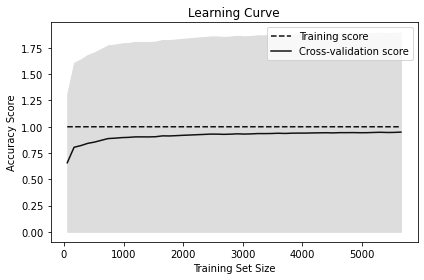

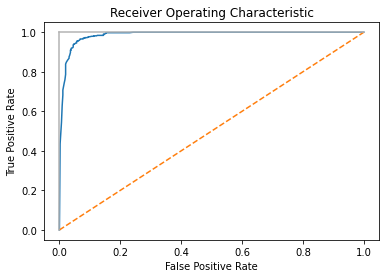

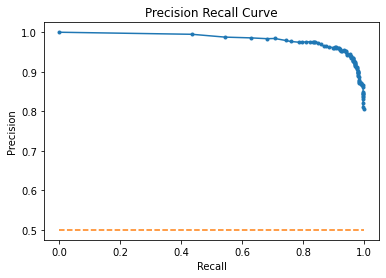

Best F1 score: 0.9456159822419533 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,ROCAUC
0,0.944507,0.926087,0.965986,0.945616,0.985879


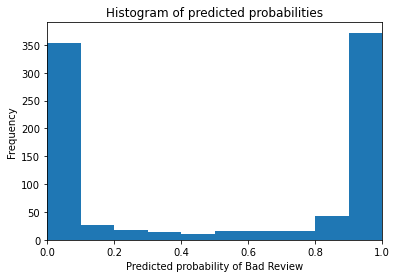

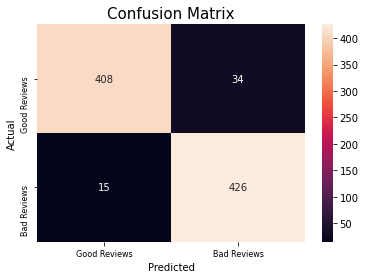

In [47]:
run_mod(rf,X_train_fp,y_train,X_val_fp,y_val)
rf_results1 = run_mod.results
rf_results1

### Support Vector Machines

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       442
           1       0.93      0.98      0.95       441

    accuracy                           0.95       883
   macro avg       0.95      0.95      0.95       883
weighted avg       0.95      0.95      0.95       883



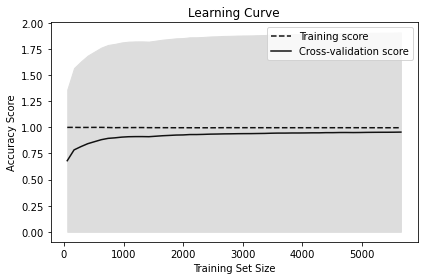

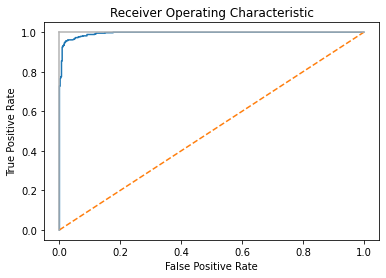

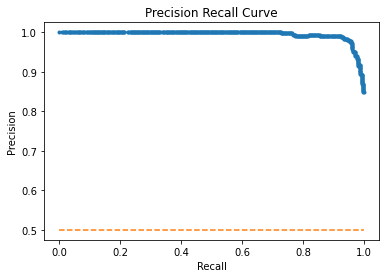

Best F1 score: 0.954696132596685 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,ROCAUC
0,0.953567,0.931034,0.979592,0.954696,0.994724


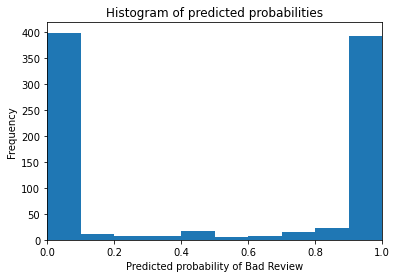

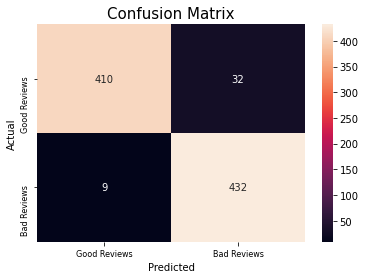

In [48]:
run_mod(svm,X_train_fp,y_train,X_val_fp,y_val)
svm_results1 = run_mod.results
svm_results1

## Feature Presence Bigram

### Naive Bayes

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       442
           1       0.97      0.94      0.96       441

    accuracy                           0.96       883
   macro avg       0.96      0.96      0.96       883
weighted avg       0.96      0.96      0.96       883



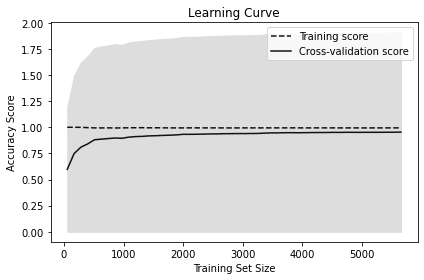

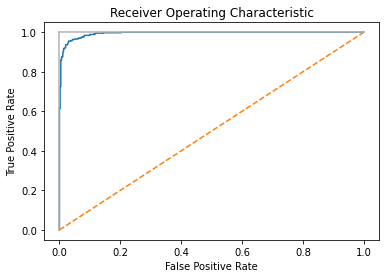

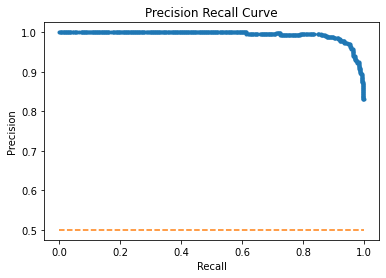

Best F1 score: 0.957422324510932 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,ROCAUC
0,0.958097,0.971963,0.943311,0.957422,0.993774


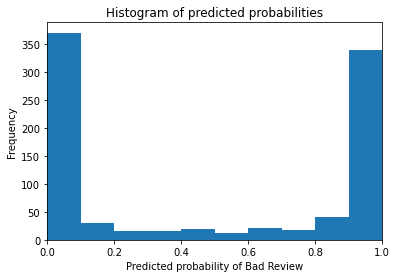

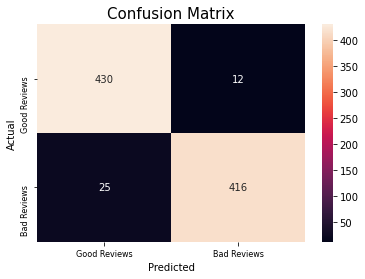

In [49]:
run_mod(nb,X_train_fp_big,y_train,X_val_fp_big,y_val)
nb_results2 = run_mod.results
nb_results2

### Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       442
           1       0.94      0.97      0.95       441

    accuracy                           0.95       883
   macro avg       0.95      0.95      0.95       883
weighted avg       0.95      0.95      0.95       883



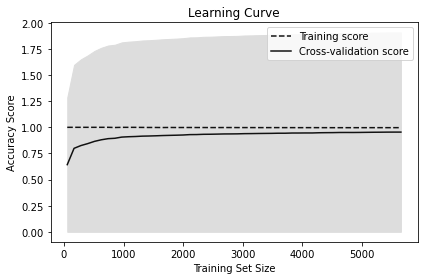

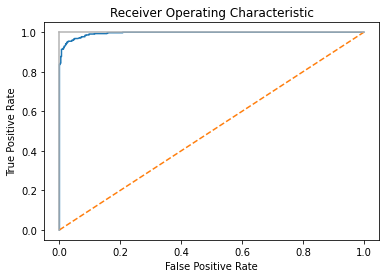

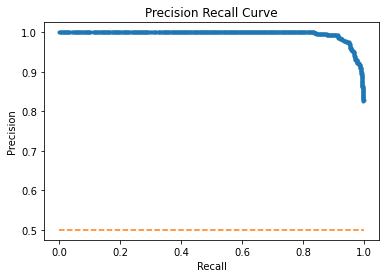

Best F1 score: 0.953229398663697 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,ROCAUC
0,0.952435,0.936543,0.970522,0.953229,0.994888


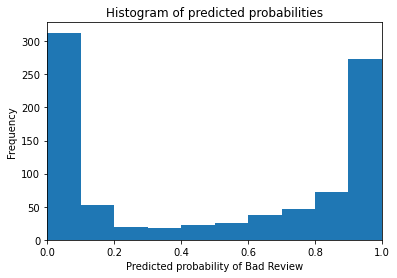

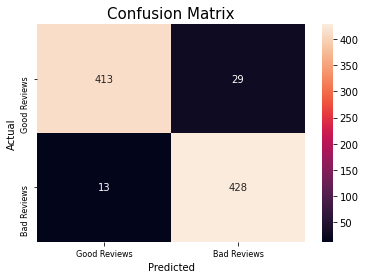

In [50]:
run_mod(lr,X_train_fp_big,y_train,X_val_fp_big,y_val)
lr_results2 = run_mod.results
lr_results2

### Random Forest

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       442
           1       0.92      0.97      0.94       441

    accuracy                           0.94       883
   macro avg       0.94      0.94      0.94       883
weighted avg       0.94      0.94      0.94       883



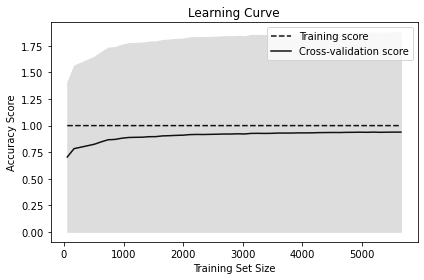

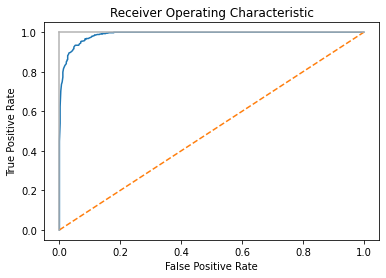

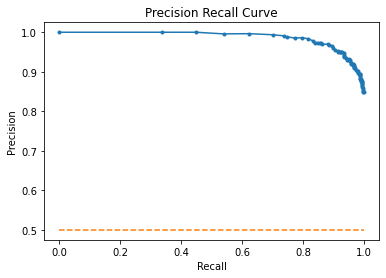

Best F1 score: 0.9415656008820288 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,ROCAUC
0,0.939977,0.916309,0.968254,0.941566,0.988336


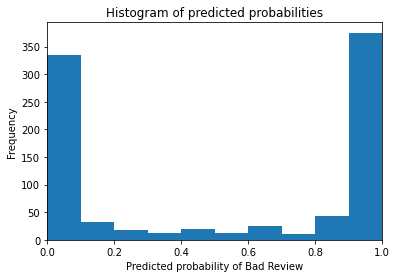

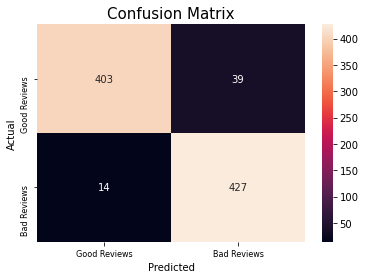

In [51]:
run_mod(rf,X_train_fp_big,y_train,X_val_fp_big,y_val)
rf_results2 = run_mod.results
rf_results2

### Support Vector Machines

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       442
           1       0.92      0.98      0.95       441

    accuracy                           0.95       883
   macro avg       0.95      0.95      0.95       883
weighted avg       0.95      0.95      0.95       883



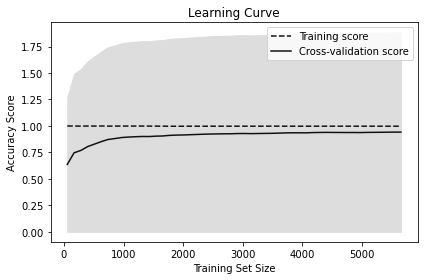

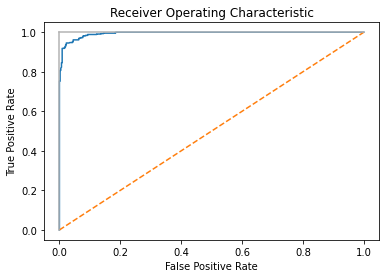

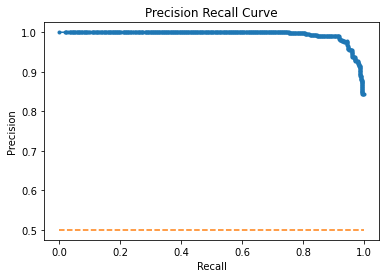

Best F1 score: 0.9495614035087719 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,ROCAUC
0,0.947905,0.919321,0.981859,0.949561,0.993954


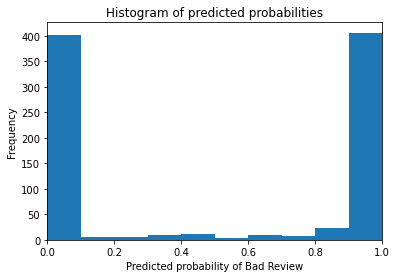

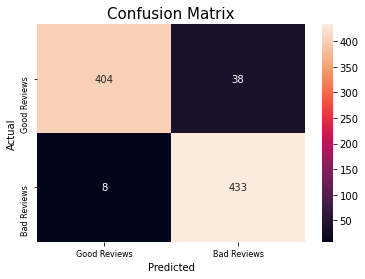

In [52]:
run_mod(svm,X_train_fp_big,y_train,X_val_fp_big,y_val)
svm_results2 = run_mod.results
svm_results2

## BOW

### Naive Bayes

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       442
           1       0.97      0.94      0.96       441

    accuracy                           0.96       883
   macro avg       0.96      0.96      0.96       883
weighted avg       0.96      0.96      0.96       883



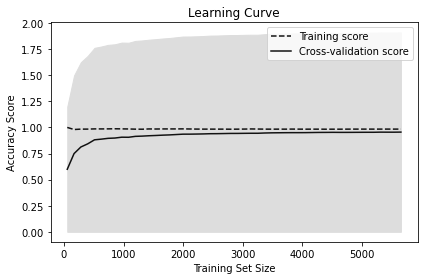

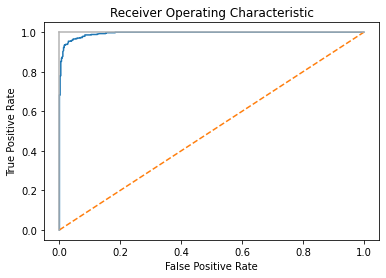

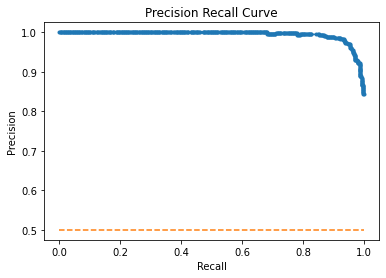

Best F1 score: 0.957422324510932 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,ROCAUC
0,0.958097,0.971963,0.943311,0.957422,0.994093


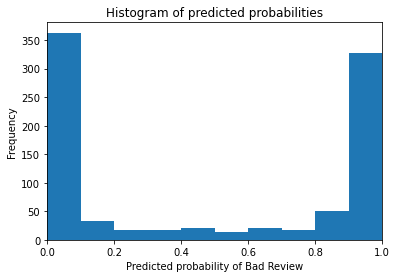

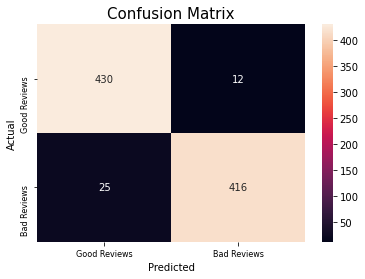

In [53]:
run_mod(nb,X_train_bow,y_train,X_val_bow,y_val)
nb_results3 = run_mod.results
nb_results3

### Logistic Regression

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       442
           1       0.94      0.98      0.96       441

    accuracy                           0.96       883
   macro avg       0.96      0.96      0.96       883
weighted avg       0.96      0.96      0.96       883



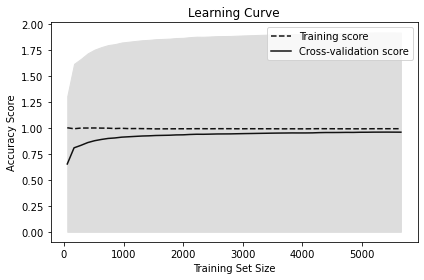

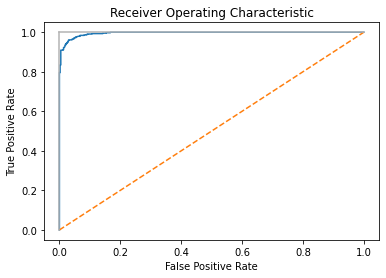

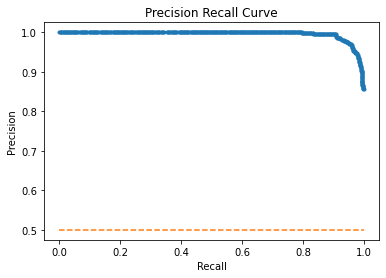

Best F1 score: 0.9599109131403119 Best threshold value: 0.1


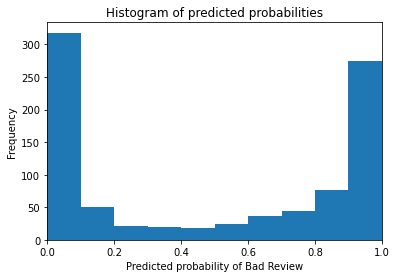

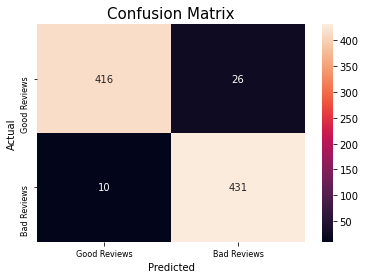

In [54]:
run_mod(lr,X_train_bow,y_train,X_val_bow,y_val)

In [55]:
lr_results3 = run_mod.results
lr_results3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.95923,0.943107,0.977324,0.959911,0.995401


### Random Forest

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       442
           1       0.92      0.97      0.94       441

    accuracy                           0.94       883
   macro avg       0.94      0.94      0.94       883
weighted avg       0.94      0.94      0.94       883



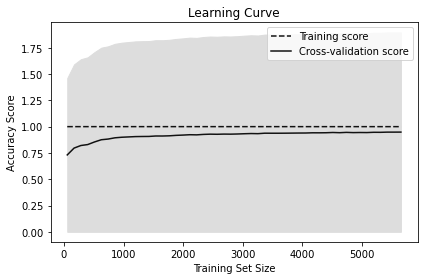

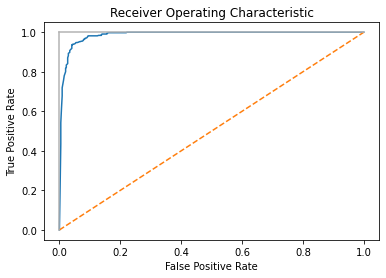

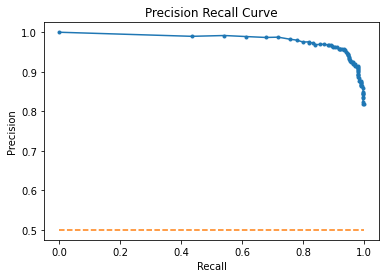

Best F1 score: 0.9424778761061946 Best threshold value: 0.1


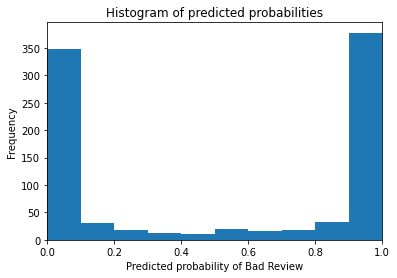

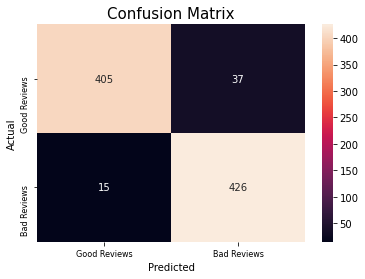

In [56]:
run_mod(rf,X_train_bow,y_train,X_val_bow,y_val)

In [57]:
rf_results3 = run_mod.results
rf_results3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.94111,0.920086,0.965986,0.942478,0.986033


### SVM

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       442
           1       0.93      0.98      0.95       441

    accuracy                           0.95       883
   macro avg       0.95      0.95      0.95       883
weighted avg       0.95      0.95      0.95       883



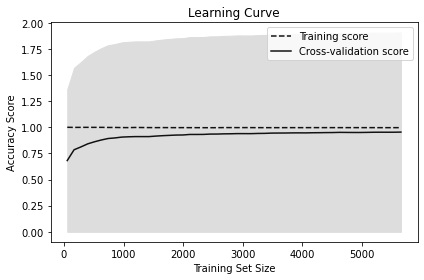

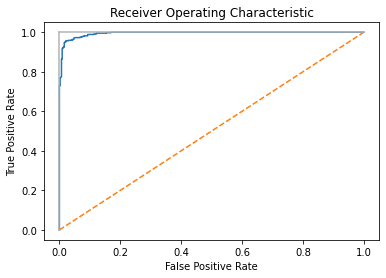

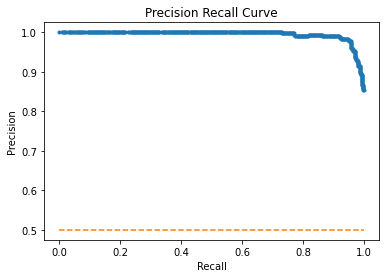

Best F1 score: 0.9535398230088495 Best threshold value: 0.1


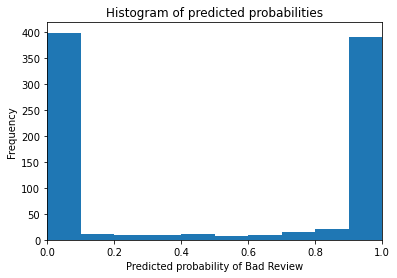

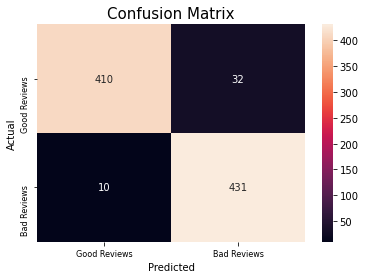

In [58]:
run_mod(svm,X_train_bow,y_train,X_val_bow,y_val)

In [59]:
svm_results3 = run_mod.results
svm_results3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.952435,0.930886,0.977324,0.95354,0.994626


## NGRAMs

### Naive Bayes

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       442
           1       0.95      0.93      0.94       441

    accuracy                           0.94       883
   macro avg       0.94      0.94      0.94       883
weighted avg       0.94      0.94      0.94       883



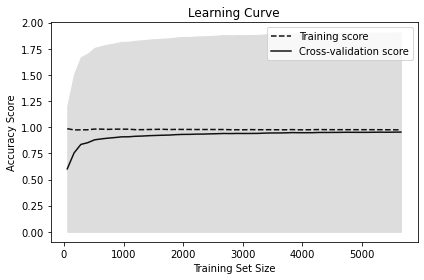

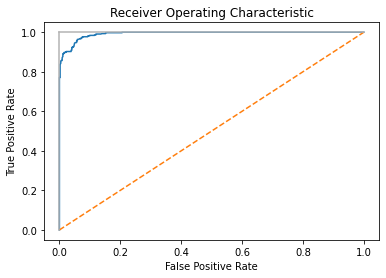

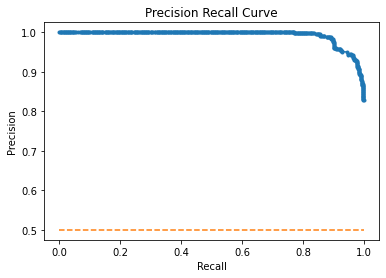

Best F1 score: 0.939150401836969 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,ROCAUC
0,0.939977,0.951163,0.927438,0.93915,0.992394


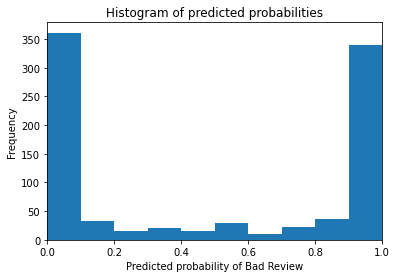

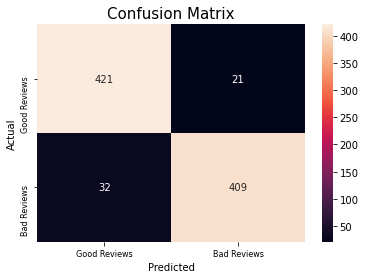

In [60]:
run_mod(nb,X_train_ngram,y_train,X_val_ngram,y_val)
nb_results4 = run_mod.results
nb_results4

### Logistic Regression

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       442
           1       0.94      0.98      0.96       441

    accuracy                           0.96       883
   macro avg       0.96      0.96      0.96       883
weighted avg       0.96      0.96      0.96       883



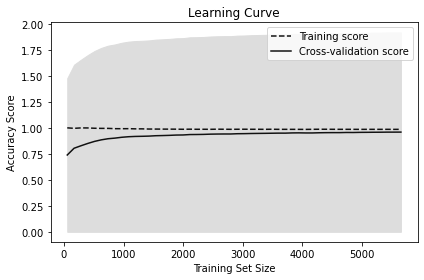

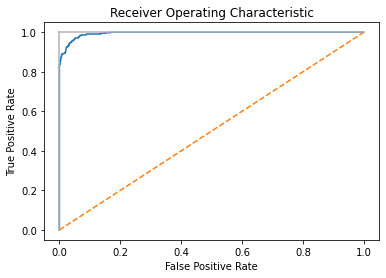

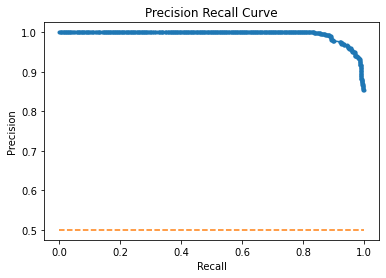

Best F1 score: 0.9577777777777778 Best threshold value: 0.1


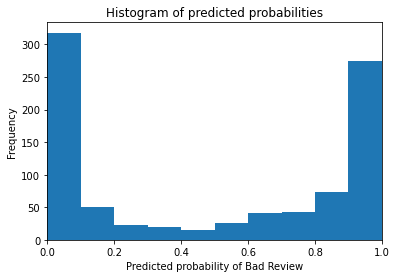

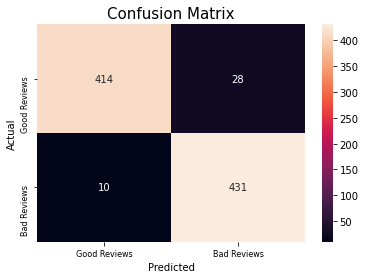

In [61]:
run_mod(lr,X_train_ngram,y_train,X_val_ngram,y_val)

In [62]:
lr_results4 = run_mod.results
lr_results4

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.956965,0.938998,0.977324,0.957778,0.994544


### Random Forest

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       442
           1       0.93      0.94      0.94       441

    accuracy                           0.94       883
   macro avg       0.94      0.94      0.94       883
weighted avg       0.94      0.94      0.94       883



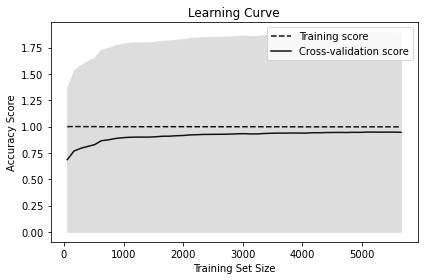

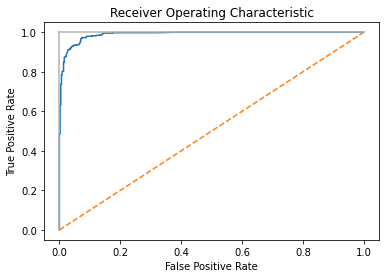

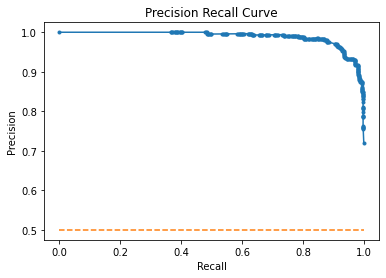

Best F1 score: 0.9378531073446327 Best threshold value: 0.1


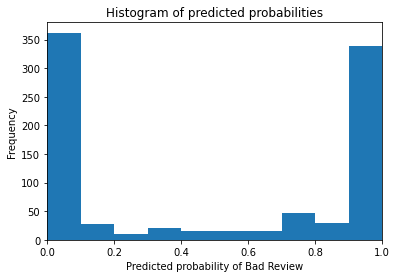

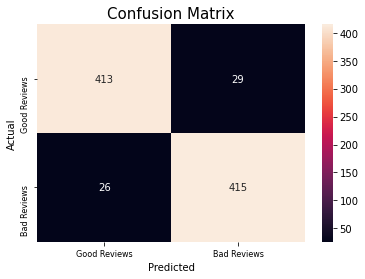

In [63]:
run_mod(rf,X_train_ngram,y_train,X_val_ngram,y_val)

In [64]:
rf_results4 = run_mod.results
rf_results4

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.937712,0.934685,0.941043,0.937853,0.989339


### Support Vector Machine

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       442
           1       0.94      0.97      0.96       441

    accuracy                           0.96       883
   macro avg       0.96      0.96      0.96       883
weighted avg       0.96      0.96      0.96       883



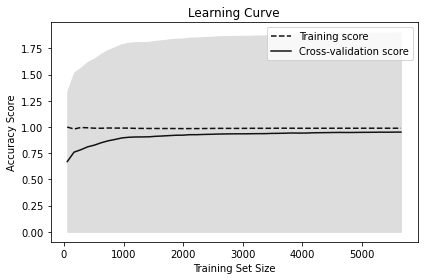

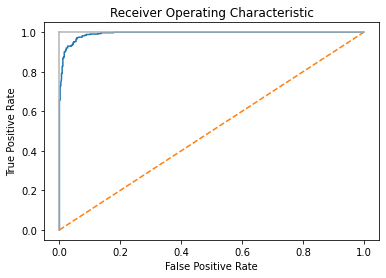

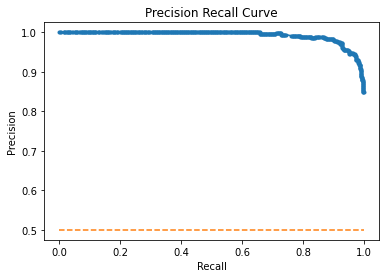

Best F1 score: 0.9565217391304347 Best threshold value: 0.1


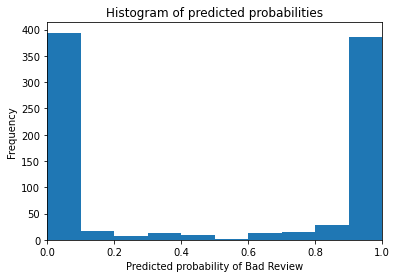

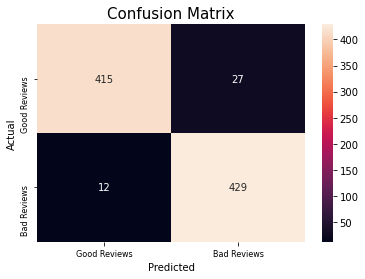

In [65]:
run_mod(svm,X_train_ngram,y_train,X_val_ngram,y_val)

In [66]:
svm_results4 = run_mod.results
svm_results4

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.955832,0.940789,0.972789,0.956522,0.9926


## TFIDF Unigram

### Naive Bayes

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       442
           1       0.96      0.95      0.96       441

    accuracy                           0.96       883
   macro avg       0.96      0.96      0.96       883
weighted avg       0.96      0.96      0.96       883



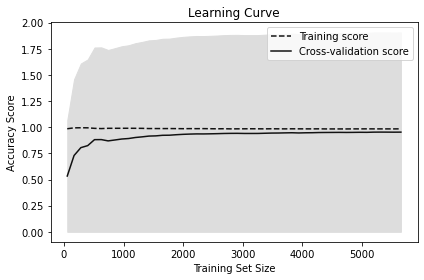

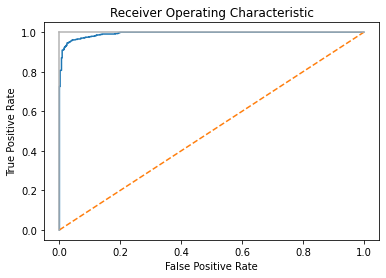

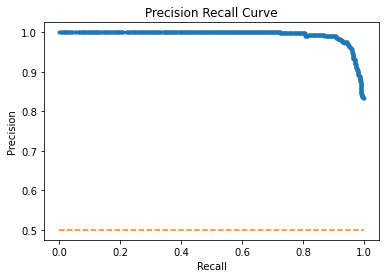

Best F1 score: 0.9578107183580388 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,ROCAUC
0,0.958097,0.963303,0.952381,0.957811,0.993159


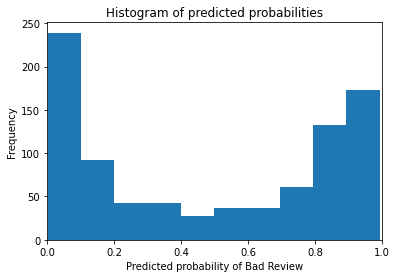

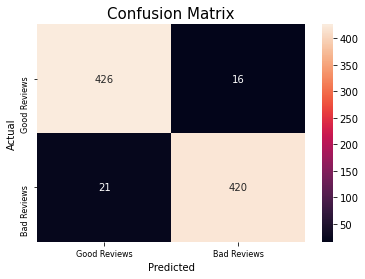

In [67]:
run_mod(nb,X_train_tfidf1,y_train,X_val_tfidf1,y_val)
nb_results5 = run_mod.results
nb_results5

### Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       442
           1       0.94      0.97      0.96       441

    accuracy                           0.96       883
   macro avg       0.96      0.96      0.96       883
weighted avg       0.96      0.96      0.96       883



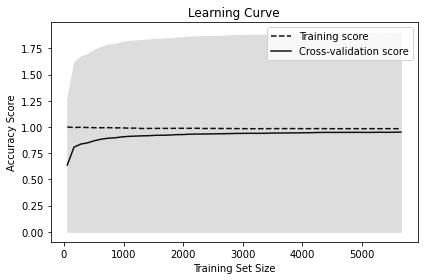

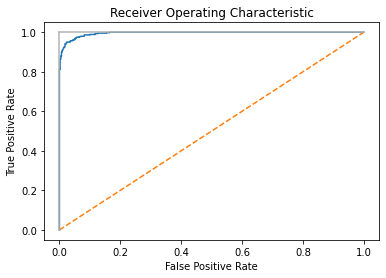

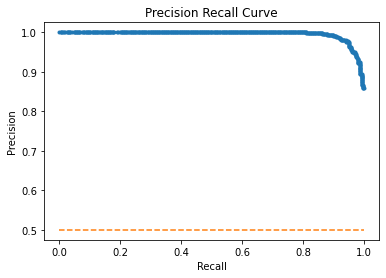

Best F1 score: 0.958659217877095 Best threshold value: 0.1


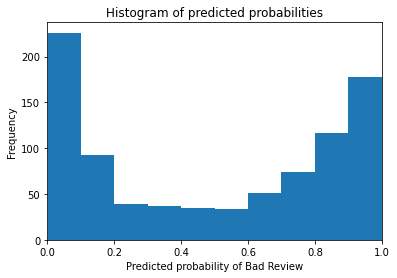

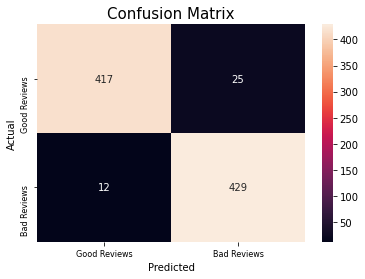

In [68]:
run_mod(lr,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [69]:
lr_results5 = run_mod.results
lr_results5

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.958097,0.944934,0.972789,0.958659,0.995098


### Random Forest

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       442
           1       0.93      0.96      0.95       441

    accuracy                           0.95       883
   macro avg       0.95      0.95      0.95       883
weighted avg       0.95      0.95      0.95       883



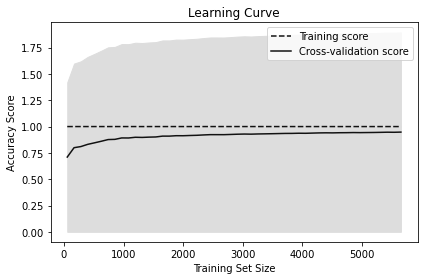

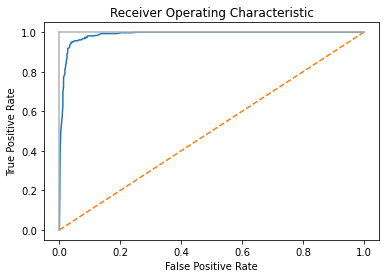

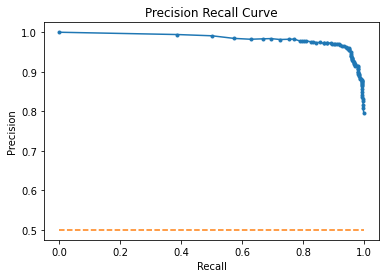

Best F1 score: 0.9464285714285714 Best threshold value: 0.1


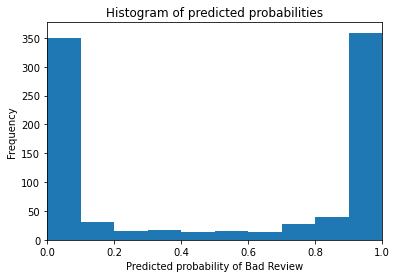

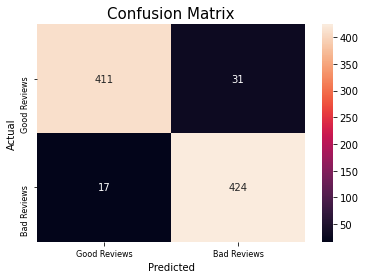

In [70]:
run_mod(rf,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [71]:
rf_results5 = run_mod.results
rf_results5

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.94564,0.931868,0.961451,0.946429,0.986851


### Support Vector Machine

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       442
           1       0.97      0.98      0.97       441

    accuracy                           0.97       883
   macro avg       0.97      0.97      0.97       883
weighted avg       0.97      0.97      0.97       883



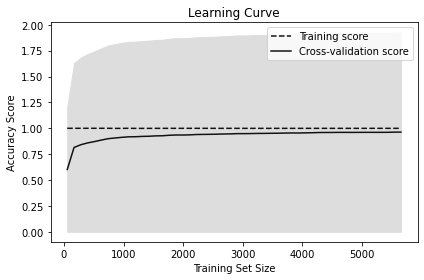

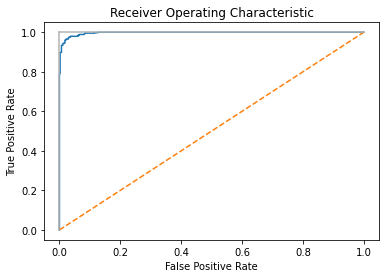

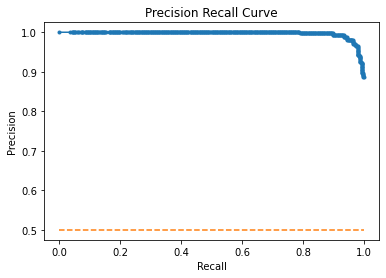

Best F1 score: 0.9706546275395034 Best threshold value: 0.1


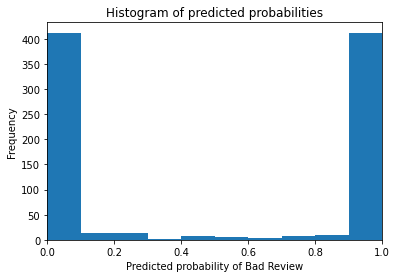

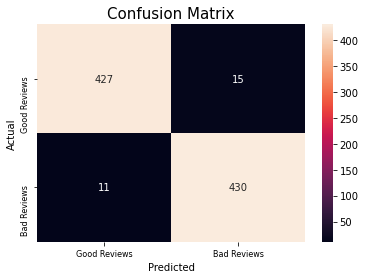

In [72]:
run_mod(svm,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [73]:
svm_results5 = run_mod.results
svm_results5

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.970555,0.966292,0.975057,0.970655,0.996858


## TFIDF Bigrams

### Naive Bayes

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       442
           1       0.95      0.93      0.94       441

    accuracy                           0.94       883
   macro avg       0.94      0.94      0.94       883
weighted avg       0.94      0.94      0.94       883



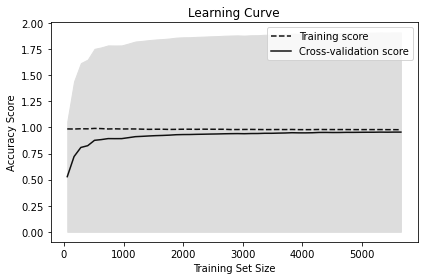

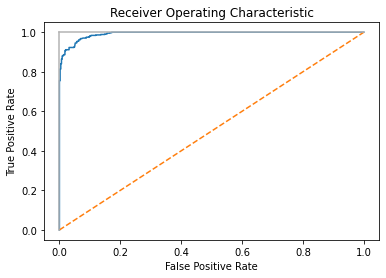

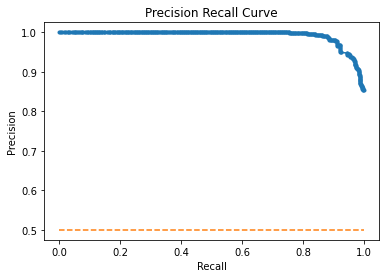

Best F1 score: 0.936854190585534 Best threshold value: 0.1


,Accuracy,Precision,Recall,F1,ROCAUC
0,0.937712,0.948837,0.92517,0.936854,0.992102


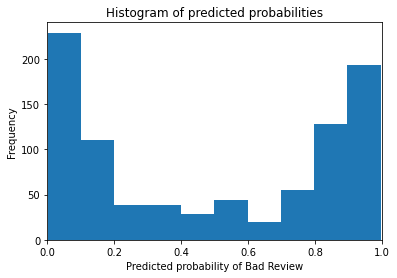

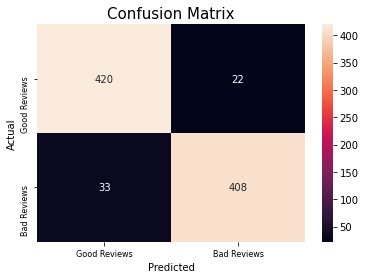

In [74]:
run_mod(nb,X_train_tfidf2,y_train,X_val_tfidf2,y_val)
nb_results6 = run_mod.results
nb_results6

### Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       442
           1       0.94      0.97      0.96       441

    accuracy                           0.95       883
   macro avg       0.96      0.95      0.95       883
weighted avg       0.96      0.95      0.95       883



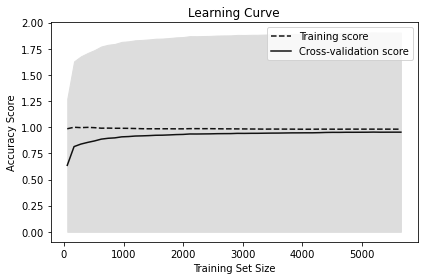

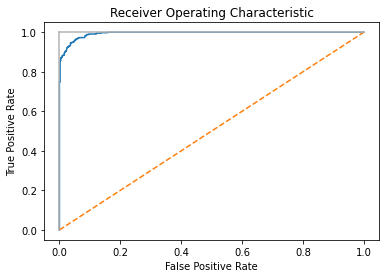

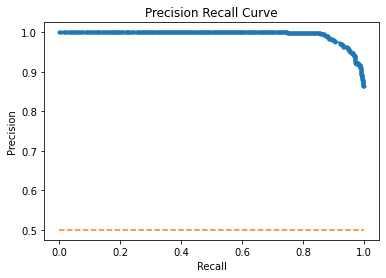

Best F1 score: 0.9552572706935123 Best threshold value: 0.1


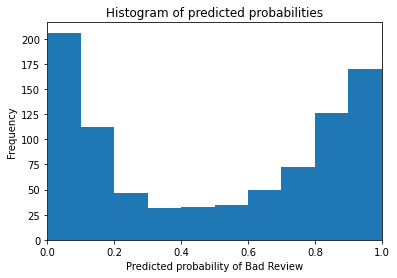

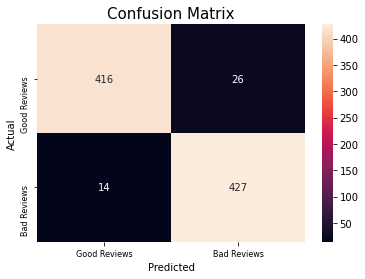

In [75]:
run_mod(lr,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [76]:
lr_results6 = run_mod.results
lr_results6

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.9547,0.942605,0.968254,0.955257,0.993815


### Random Forest

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       442
           1       0.94      0.96      0.95       441

    accuracy                           0.95       883
   macro avg       0.95      0.95      0.95       883
weighted avg       0.95      0.95      0.95       883



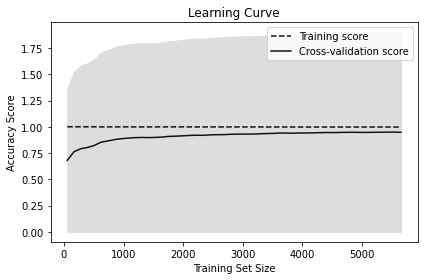

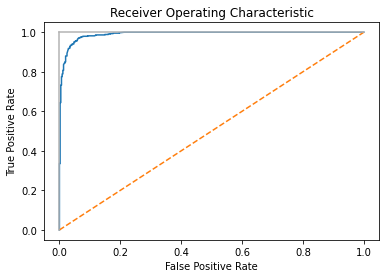

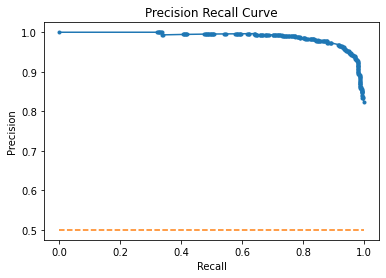

Best F1 score: 0.9493813273340832 Best threshold value: 0.1


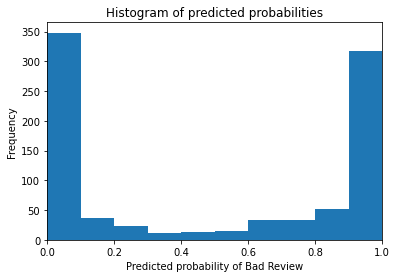

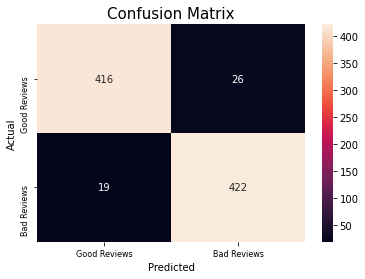

In [77]:
run_mod(rf,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [78]:
rf_results6 = run_mod.results
rf_results6

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.949037,0.941964,0.956916,0.949381,0.989809


### SVM

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       442
           1       0.96      0.97      0.96       441

    accuracy                           0.96       883
   macro avg       0.96      0.96      0.96       883
weighted avg       0.96      0.96      0.96       883



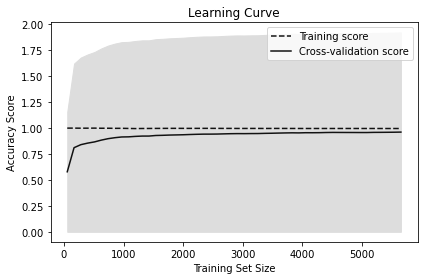

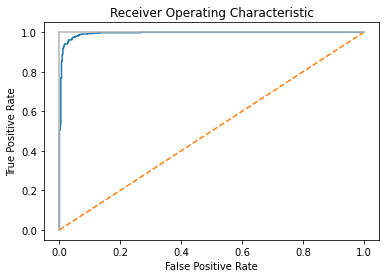

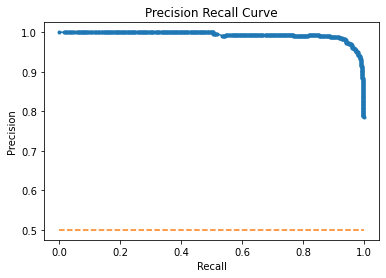

Best F1 score: 0.963882618510158 Best threshold value: 0.1


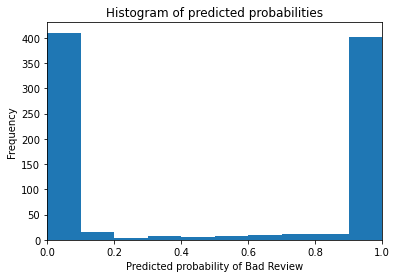

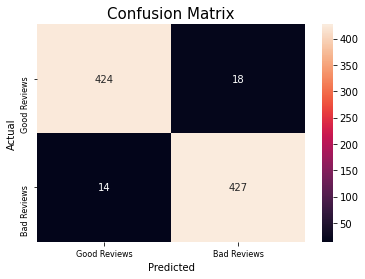

In [79]:
run_mod(svm,X_train_tfidf2,y_train,X_val_tfidf2,y_val)

In [80]:
svm_results6 = run_mod.results
svm_results6

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.96376,0.959551,0.968254,0.963883,0.993785


# Section 10: Summarised Results Tables

### Feature Presence

In [81]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]

model_summary_fp = pd.concat([nb_results1,lr_results1,rf_results1,svm_results1])
model_summary_fp.set_index([models],inplace = True)
model_summary_fp
model_summary_fp.sort_values(by = "Accuracy",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Multinomial NB,0.958097,0.971963,0.943311,0.957422,0.994036
Logistic Regression,0.958097,0.942982,0.975057,0.958751,0.995396
Support Vector Machine,0.953567,0.931034,0.979592,0.954696,0.994724
Random Forest,0.944507,0.926087,0.965986,0.945616,0.985879


### Feature Presence Ngram

In [82]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]

model_summary_fp_ngram = pd.concat([nb_results2,lr_results2,rf_results2,svm_results2])
model_summary_fp_ngram.set_index([models],inplace = True)
model_summary_fp_ngram
model_summary_fp_ngram.sort_values(by = "Accuracy",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Multinomial NB,0.958097,0.971963,0.943311,0.957422,0.993774
Logistic Regression,0.952435,0.936543,0.970522,0.953229,0.994888
Support Vector Machine,0.947905,0.919321,0.981859,0.949561,0.993954
Random Forest,0.939977,0.916309,0.968254,0.941566,0.988336


### BOWs

In [83]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector Machine"]

model_summary_bow = pd.concat([nb_results3,lr_results3,rf_results3,svm_results3])
model_summary_bow.set_index([models],inplace = True)
model_summary_bow
model_summary_bow.sort_values(by = "Accuracy",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Logistic Regression,0.959230,0.943107,0.977324,0.959911,0.995401
Multinomial NB,0.958097,0.971963,0.943311,0.957422,0.994093
Support Vector Machine,0.952435,0.930886,0.977324,0.953540,0.994626
Random Forest,0.941110,0.920086,0.965986,0.942478,0.986033


In [84]:
# Save to csv
#model_summary_bow.to_csv("model_summary_bow.csv")

### BOW Ngram

In [85]:
model_summary_bow_ngram = pd.concat([nb_results4,lr_results4,rf_results4,svm_results4])
model_summary_bow_ngram.set_index([models],inplace = True)
model_summary_bow_ngram.sort_values(by = "Accuracy",ascending = False)
model_summary_bow_ngram

,Accuracy,Precision,Recall,F1,ROCAUC
Multinomial NB,0.939977,0.951163,0.927438,0.939150,0.992394
Logistic Regression,0.956965,0.938998,0.977324,0.957778,0.994544
Random Forest,0.937712,0.934685,0.941043,0.937853,0.989339
Support Vector Machine,0.955832,0.940789,0.972789,0.956522,0.992600


In [86]:
# Save to csv
#model_summary_ngram.to_csv("model_summary_ngram.csv")

### TFIDF 

In [87]:
model_summary_tfidf1 = pd.concat([nb_results5,lr_results5,rf_results5,svm_results5])
model_summary_tfidf1.set_index([models],inplace = True)
model_summary_tfidf1.sort_values(by = "Accuracy",ascending = False)
model_summary_tfidf1

,Accuracy,Precision,Recall,F1,ROCAUC
Multinomial NB,0.958097,0.963303,0.952381,0.957811,0.993159
Logistic Regression,0.958097,0.944934,0.972789,0.958659,0.995098
Random Forest,0.945640,0.931868,0.961451,0.946429,0.986851
Support Vector Machine,0.970555,0.966292,0.975057,0.970655,0.996858


In [88]:
# Save to csv
#model_summary_tfidf1.to_csv("model_summary_tfidf_bow.csv")

### TFIDF Ngram

In [89]:
model_summary_tfidf2 = pd.concat([nb_results6,lr_results6,rf_results6,svm_results6])
model_summary_tfidf2.set_index([models],inplace = True)
model_summary_tfidf2.sort_values(by = "Accuracy",ascending = False)
model_summary_tfidf2

,Accuracy,Precision,Recall,F1,ROCAUC
Multinomial NB,0.937712,0.948837,0.925170,0.936854,0.992102
Logistic Regression,0.954700,0.942605,0.968254,0.955257,0.993815
Random Forest,0.949037,0.941964,0.956916,0.949381,0.989809
Support Vector Machine,0.963760,0.959551,0.968254,0.963883,0.993785


### Summary of all models

In [90]:
all_ml_models = pd.concat([model_summary_fp,model_summary_fp_ngram,model_summary_bow,model_summary_bow_ngram,model_summary_tfidf1,model_summary_tfidf2])
all_ml_models.index = ['Multinomial NB FP', 'Logistic Regression FP', 'Random Forest FP','Support Vector Machine FP',
                       'Multinomial NB FP BIG', 'Logistic Regression FP BIG', 'Random Forest FP BIG','Support Vector Machine FP BIG',
                       'Multinomial NB BOW', 'Logistic Regression BOW', 'Random Forest BOW',
                       'Support Vector Machine BOW','Multinomial NB BIG', 'Logistic Regression BIG', 'Random Forest BIG',
                       'Support Vector Machine BIG','Multinomial NB TFIDF', 'Logistic Regression TFIDF', 'Random Forest TFIDF',
                       'Support Vector Machine TFIDF','Multinomial NB TFIDF BIG', 'Logistic Regression TFIDF BIG', 'Random Forest TFIDF BIG',
                       'Support Vector Machine TFIDF BIG']

In [91]:
# Sorted by Accuracy
all_ml_models.sort_values(by = "Accuracy",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Support Vector Machine TFIDF,0.970555,0.966292,0.975057,0.970655,0.996858
Support Vector Machine TFIDF BIG,0.963760,0.959551,0.968254,0.963883,0.993785
Logistic Regression BOW,0.959230,0.943107,0.977324,0.959911,0.995401
Multinomial NB BOW,0.958097,0.971963,0.943311,0.957422,0.994093
Logistic Regression TFIDF,0.958097,0.944934,0.972789,0.958659,0.995098
Multinomial NB TFIDF,0.958097,0.963303,0.952381,0.957811,0.993159
Logistic Regression FP,0.958097,0.942982,0.975057,0.958751,0.995396
Multinomial NB FP,0.958097,0.971963,0.943311,0.957422,0.994036
Multinomial NB FP BIG,0.958097,0.971963,0.943311,0.957422,0.993774
Logistic Regression BIG,0.956965,0.938998,0.977324,0.957778,0.994544


In [ ]:
# Sorted by accuracy top 5
all_ml_models.sort_values(by = "Accuracy",ascending = False).head(5)

In [93]:
# Sorted by recall
all_ml_models.sort_values(by = "Recall",ascending = False).head(5)

,Accuracy,Precision,Recall,F1,ROCAUC
Support Vector Machine FP BIG,0.947905,0.919321,0.981859,0.949561,0.993954
Support Vector Machine FP,0.953567,0.931034,0.979592,0.954696,0.994724
Logistic Regression BOW,0.959230,0.943107,0.977324,0.959911,0.995401
Support Vector Machine BOW,0.952435,0.930886,0.977324,0.953540,0.994626
Logistic Regression BIG,0.956965,0.938998,0.977324,0.957778,0.994544


In [94]:
# Sorted by F1-score
all_ml_models.sort_values(by = "F1",ascending = False).head(5)

,Accuracy,Precision,Recall,F1,ROCAUC
Support Vector Machine TFIDF,0.970555,0.966292,0.975057,0.970655,0.996858
Support Vector Machine TFIDF BIG,0.963760,0.959551,0.968254,0.963883,0.993785
Logistic Regression BOW,0.959230,0.943107,0.977324,0.959911,0.995401
Logistic Regression FP,0.958097,0.942982,0.975057,0.958751,0.995396
Logistic Regression TFIDF,0.958097,0.944934,0.972789,0.958659,0.995098


In [95]:
# Sorted by ROCAUC
all_ml_models.sort_values(by = "ROCAUC",ascending = False).head()

,Accuracy,Precision,Recall,F1,ROCAUC
Support Vector Machine TFIDF,0.970555,0.966292,0.975057,0.970655,0.996858
Logistic Regression BOW,0.959230,0.943107,0.977324,0.959911,0.995401
Logistic Regression FP,0.958097,0.942982,0.975057,0.958751,0.995396
Logistic Regression TFIDF,0.958097,0.944934,0.972789,0.958659,0.995098
Logistic Regression FP BIG,0.952435,0.936543,0.970522,0.953229,0.994888


In [96]:
final_text_models = all_ml_models.sort_values(by = "ROCAUC",ascending = False)
final_text_models.to_csv("TextSentimentModels.csv")

* Recall is highest for the SVM Feature Presence Bigrams.
* Accuracy, F1 and AUROC is highest for SVM TFIDF

# Section 11: Hyperparameter Tuning

In [99]:
best_model = SVC()
best_model.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [100]:
# Using tfidf1
parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid','linear']}
svm = SVC()
clf = GridSearchCV(svm,param_grid=parameters, cv = 10, scoring = 'accuracy')
clf.fit(X_train_tfidf1,y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring='accuracy')

In [101]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf)

Best parameters are: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.9695647731507266
Best estimator: SVC(C=10, gamma=0.1)




## Best Model based on Hyperparameter Tuning Against Validation Set

In [102]:
# Set up the best model
best_model = SVC(C=10, gamma=0.1,kernel='rbf', probability = True)
best_model.fit(X_train_tfidf1,y_train)

SVC(C=10, gamma=0.1, probability=True)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       442
           1       0.97      0.98      0.97       441

    accuracy                           0.97       883
   macro avg       0.97      0.97      0.97       883
weighted avg       0.97      0.97      0.97       883



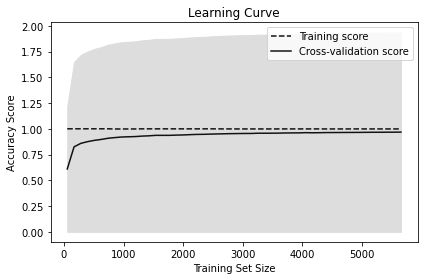

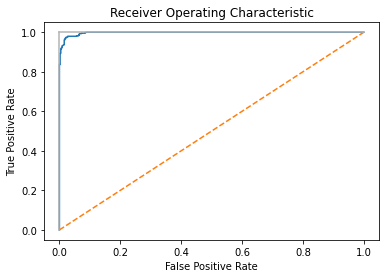

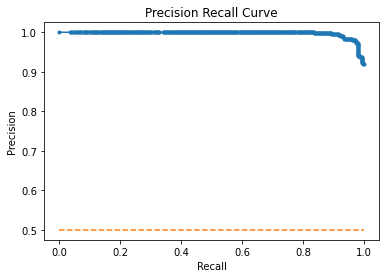

Best F1 score: 0.9739524348810872 Best threshold value: 0.1


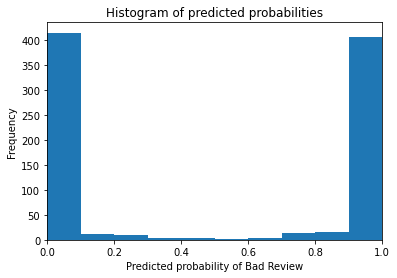

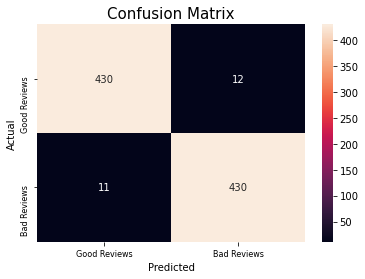

In [131]:
run_mod(best_model,X_train_tfidf1,y_train,X_val_tfidf1,y_val)

In [132]:
best_model_results = run_mod.results
best_model_results.index = ["SVM TFIDF"]
best_model_results

,Accuracy,Precision,Recall,F1,ROCAUC
SVM TFIDF,0.973952,0.972851,0.975057,0.973952,0.997386


In [218]:
#filename = 'final_sentiment_model.sav'
#pickle.dump(best_model, open(filename, 'wb'))

## Best Model Against the Test Set

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       441
           1       0.98      0.98      0.98       442

    accuracy                           0.98       883
   macro avg       0.98      0.98      0.98       883
weighted avg       0.98      0.98      0.98       883



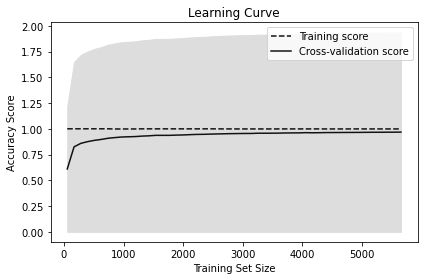

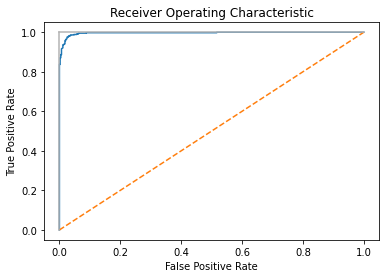

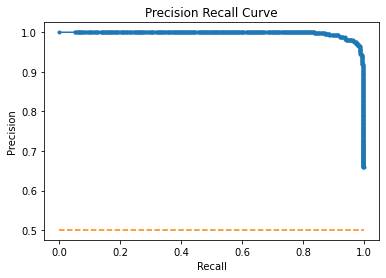

Best F1 score: 0.9751131221719457 Best threshold value: 0.1


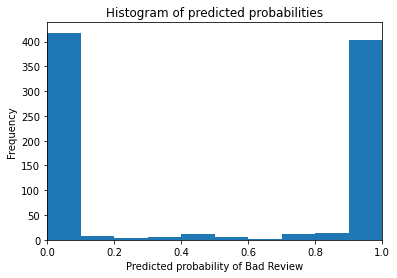

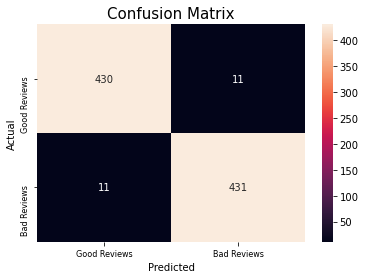

In [127]:
run_mod(best_model,X_train_tfidf1,y_train,X_test_tfidf1,y_test)

In [128]:
best_test = run_mod.results
best_test.index = ["SVM TFIDF"]
best_test

,Accuracy,Precision,Recall,F1,ROCAUC
SVM TFIDF,0.975085,0.975113,0.975113,0.975113,0.996401
